# Wave field modelling 

In this notebook example it is demonstrated how we can solve the 1D and 2D wave equation using the *wave_fields* module from the *hmc_marine* package. In this notebook we demonstrate

1. [Theoretical Background](#theory)
2. [How to simulate one wave](#onewave)
3. [Comparing three wave construction methods: DFTpolar, DFTcartesian, FFT](#comparewaves)
4. [Simulating a Gauss wave](#gausswave)

<a id='theory'></a>

### Theorerical Background

##### wave model and mesh resolution
This section gives some backgroud on the wave field modelling implemented in the *wave_field* model package The wave_package gives a more eleborate discussion, but in short here,  we discuss in the modelling of 1D propagating waves (or 2D Waves if you count time as a dimension). The following equation is solved

$$\eta(x_p, t) = \sum_i^{n_k} a_i \cos(k_i x_p - \omega_i t + \phi_i)~~~~~p=1,2\dots,n_x$$,

where $\eta$ is the wave height at the position $x_p$ on $n_x$ descrite points, $a_i$ is the amplitude of the wave component $i$, $k_i$ is the wave vector belonging to the wave component $i$ and $\phi_i$ is a random phase between $0\sim 2\pi$. The wave amplitudes $a_i$ are set as

$$a_i = \sqrt{2S(k_i)\Delta k_i}$$

where $S(k)$ is the underlying wave spectrum we want to impose and $\Delta k_i$ is the spacing between the wave vector nodes $k_i$ and $k_{i+1}$. The wave spectrum is defined in wave vector space $k$ which is related to the angular frequency via the deep water dispersion relation as 

$$ k = \omega^2/g_0 $$

##### Solution methods

The key points of the equation shown above is that in order to model a wave, for the spatial domain $x$ we have to specify a length $L_x$ and number of points $n_x$, and for the wave vector domain $k$ we have to specify a range *k_min*/*k_max* and  number of points $n_k$. Also we need to specify the spectrum, either Jonsswap or Gauss at the moment

In order to solve the wave equation we can either directly implement the wave equation above as a discrete sum of wave components, which is then refered to as a Discrete Fourier Transfor (DFT). The benefit of a DFT is that we are not restricted to how many sample points in wave vector space we have compared to number of points in the spatial domain or what the spacing between the wave vector components is. The draw back is that the DFT is relatively slow as the calculation time increases with $\sim n_x \times n_k$. Since we can freely pick the number of wave nodes this latter is not a problem if we reduce the number of wave nodes but off course we get a less accurate discription of the wave spectrum we want to model

Alternatively we can solve the wave equation with an FFT. The restriction for using an FFT is that we have to use as many points in wave vector domain as in spatial domain and our mesh needs to be equidistant. The calculation time of a FFT increases with $\sim n_x \log(n_x)$. So incease we want to impose the maximum number of wave components on our mesh (which is when $n_k = n_x$ we still have a relatively fast calculation time compared to the DFT

Below we demonstrate how the FFT and DFT can be used to model a 1D wave. The DFT is imposed using the *DPTpolar* mode and allows to select the number of wave components out of the full set by either definnig a sub range or by picking the wave nodes at non-uniform intervals in a ways that each interval has an equal amount of energy. Then we compare the *DFTpolar* method with the *FFT* method. 

<a id='onewave'></a>

## Simulating a 1D wave using DFT

We start with create a simple Jonswap wave using an ordinary DFT without any special selection of wave nodes. 

First import all the required modules for this notebook

In [1]:
import sys
import os
import logging
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML

from hmc_utils.misc import (create_logger, Timer)
import hmc_marine.wave_fields as wf

logger = create_logger(console_log_format_clean=True, console_log_level=logging.INFO)

C:\Anaconda\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Next step is to create the wave as follows

In [2]:
wave1 = wf.Wave1D(xmax=1000, nx_points=512, n_kx_nodes=64, wave_construction="DFTpolar")
wave1.make_report()

Initialise jonswap 1D wave field
Name                                     : wave_jonswap_DFTpolar_All_1d
----------- Domain settings --------
Start x [m]                              : 0
End x [m]                                : 1000
Length x [m]                             : 1000
----------- Time settings --------
Start t [s]                              : 0
End t [s]                                : 1000000
Length t [s]                             : 1000000
Delta t [s]                              : 1.0
----------- Numerical resolutions --------
Number x - nodes                         : 512
Number kx - nodes                        : 64
Delta x [m]                              : 1.9569471624266144
Delta kx min [rad/m]                     : 0.024933333333333252
Delta kx max [rad/m]                     : 0.024933333333333474
Delta kx first [rad/m]                   : 0.02493333333333333
k-min [rad/m]                            : 0.0
k-max [rad/m]                            : 1.5708
k-

The report shows that we have a wave of 1 km (1000 m) in length and that we simulate the wave over 1000 s with a time step of 1 s. All those settings can be passed as argument to the constructor Wave1D, see the help for the details.

Since we are using the *DFTPolar* method to construct the wave we can define the wave nodes independent of the spatial resolution. Although we describe the wave in spatial domain at 512 nodes, for the k-domain we only use 64 wave vectors. We can plot this spectrum at t=0 s in k-domain as follows :


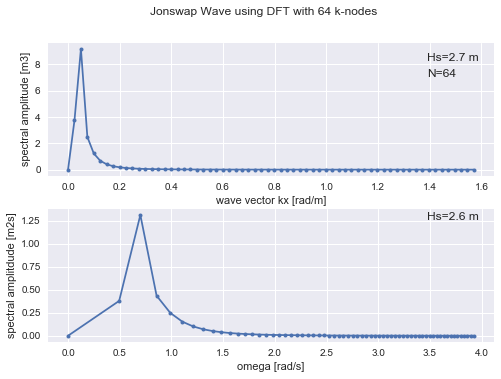

In [3]:
fig, axis = wave1.plot_spectrum(add_hs_estimate=True, plot_title="Jonswap Wave using DFT with 64 k-nodes")
plt.show()

The top figure shows the spectrum in k-space, the bottom figure give the same spectrum transform to the omega domain using the deep water dispersion relation. Note that the spectrum in k-domain is described at an equidistant mesh, and consequently the resulting transfored spectrum in omega domain is given at a non-uniform mesh.

We can plot in the spatial domain as follows:

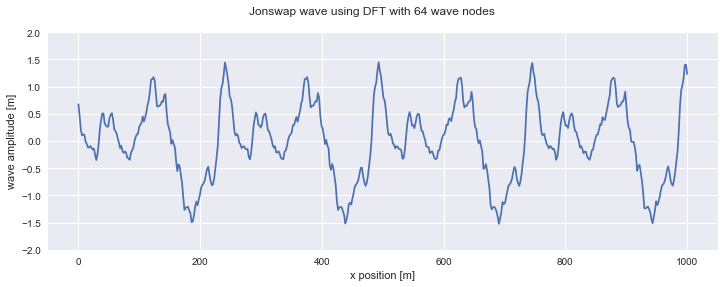

In [4]:
fig, axis = wave1.plot_wave(figsize=(12,4), plot_title="Jonswap wave using DFT with 64 wave nodes", y_min=-2, y_max=2)
plt.show()

As you can see the wave is periodic with a period of 252 m, which directly follows from our settings for the k-resolution: the maximum wave vector magnitude follows from the nyqist frequency as 1.6 rad/s (related to the sample spacing of delta_x = 1000/512 = 1.96 m, hence k_nyq = pi /delta_x). With 64 k-nodes the wave k-spacing resolution is therefore 0.025 rad/m, which leads to a maximum wave length of 2 * pi / delta_k = 252 m. We can make sure that our wave is not periodic by choosing more k-nodes. So let's try again

In [5]:
wave1 = wf.Wave1D(xmax=1000, nx_points=512, n_kx_nodes=512, wave_construction="DFTpolar")
wave1.make_report()

Initialise jonswap 1D wave field
Name                                     : wave_jonswap_DFTpolar_All_1d
----------- Domain settings --------
Start x [m]                              : 0
End x [m]                                : 1000
Length x [m]                             : 1000
----------- Time settings --------
Start t [s]                              : 0
End t [s]                                : 1000000
Length t [s]                             : 1000000
Delta t [s]                              : 1.0
----------- Numerical resolutions --------
Number x - nodes                         : 512
Number kx - nodes                        : 512
Delta x [m]                              : 1.9569471624266144
Delta kx min [rad/m]                     : 0.003073972602739561
Delta kx max [rad/m]                     : 0.003073972602739783
Delta kx first [rad/m]                   : 0.003073972602739726
k-min [rad/m]                            : 0.0
k-max [rad/m]                            : 1.5708


This time our wave becomes periodic after 2043 m (reported as L_max above). Since our domain is not longer than 1000 m it is not going to bother is. Let's plot the spectrum and wave again

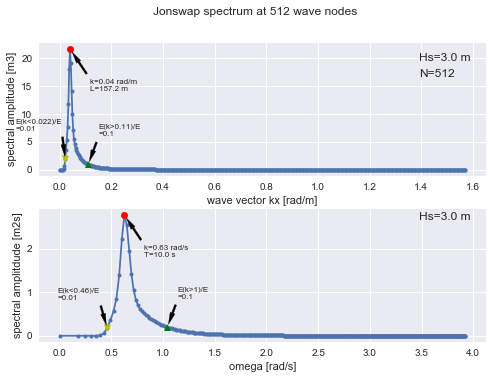

In [6]:
fig, axis = wave1.plot_spectrum(add_hs_estimate=True, add_limit_markers=True, plot_title="Jonswap spectrum at 512 wave nodes")
plt.show()

This time we have added some makers to indicate the location below which the energy below the PSD is 0.01 of the total (yellow marker) and above which the energy below the PSD is 0.1 of the total (green marker). Also the peak of the PSD is indicated with the red marker. The low and high limits can be controlled with the *E_limit_low* and *E_limit_high* input arguments of the wave constructor and can be used to select the wave frequency with in the band between the yellow and green marker. For now we are not going to do that, but we just plot the wave again

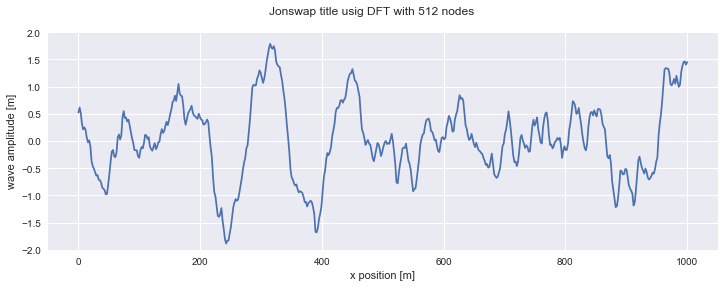

In [7]:
fig, axis = wave1.plot_wave(plot_title="Jonswap title usig DFT with 512 nodes", y_min=-2, y_max=2)
plt.show()

Indeed we can see that the wave field is not periodic over the domain size of 1000 m anymore. Moreover, the Hs which is estimated from the energy of the spectrum is now exactly 3.0 m, which was the target Hs (note that this is the default Hs value of the created spectrum. In case you want to modify that you can pass a different value to the Hs argument of the Wave1D constructor)

We can have a look at the simulation of the wave in time as well. It should be noted that we never have a periodicy in the time domain as explained in the documentation. We therefore can run the simulation infinitly long without repeating the signal. Let's play the signal over 50 seconds at a resolution of 0.1 s.


In [8]:
wave1.reset_time(nt_samples=500, delta_t=0.1)
movie1 = wave1.animate_wave(plot_title="Jonswap wave using DFT with 512 nodes", y_min=-2, y_max=2)
HTML(movie1.to_html5_video())

<a id='comparewaves'></a>

In [9]:
plt.gcf().clear()

## Comparing three different wave construction methods

As described in the wave_field manual we can use different methods to construct the wave field from the spectrum. We have now seen how to create and simulate a wave using a Discrete Fourier Transform (DFT). The number of k-nodes is independent of the number of samples in x-domain. The DFT method, however, is not very efficient. We can speed things up by making a smart selection of wave nodes. Let's make a new wave with the same length as the previous wave but now with an selection of wave bins in such a way that each bin in the spectrum respresents the same amount of energy.



In [10]:
wave2 = wf.Wave1D(xmax=1000, nx_points=512, n_kx_nodes=512, wave_selection="EqualEnergyBins",  
                  wave_construction="DFTpolar", n_bins_equal_energy=50, use_subrange_energy_limits=False)
    
wave2.make_report()


Initialise jonswap 1D wave field


C:\Anaconda\lib\site-packages\scipy\optimize\minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Name                                     : wave_jonswap_DFTpolar_EqualEnergyBins_1d
----------- Domain settings --------
Start x [m]                              : 0
End x [m]                                : 1000
Length x [m]                             : 1000
----------- Time settings --------
Start t [s]                              : 0
End t [s]                                : 1000000
Length t [s]                             : 1000000
Delta t [s]                              : 1.0
----------- Numerical resolutions --------
Number x - nodes                         : 512
Number kx - nodes                        : 51
Delta x [m]                              : 1.9569471624266144
Delta kx min [rad/m]                     : 0.0005185387366527378
Delta kx max [rad/m]                     : 0.07455579547215757
Delta kx first [rad/m]                   : 0.003073972602739726
k-min [rad/m]                            : 0.0
k-max [rad/m]                            : 0.2529975010234645
k-nyq [rad

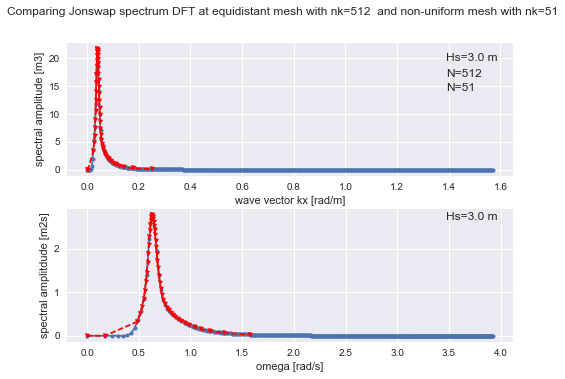

In [11]:
fig, axis=wave1.plot_spectrum(add_limit_markers=False, add_hs_estimate=True, 
                              plot_title="Comparing Jonswap spectrum DFT at equidistant mesh with nk=512  and non-uniform mesh with nk=51")
fig, axis=wave2.plot_spectrum(fig=fig, axis=axis, linecolor="r", linestyle="--", line_markers="v",
                              y_n_points_label=0.7, markersize=5)
plt.show()

In the plot above we compare the energy spectrum on the original spectrum at 512 nodes with a spectrum with non-uniform spacing in which each bin contains an equal amount of energy. In the latter spectrum the bin width around the peak is much closer, such that we better capture the details of the spectrum in this region, whereas for the tail of the spectrum the bin spacing becomes much wider. The "EqualEnergyBins" spectrum only has 51 nodes, compared to the 512 nodes of the full spectum. We would expect therefore that the wave construction also becomes significantly faster. We can check that by measuring the time needed calcute the wave field 1000 times as follows:

In [12]:
wave1.reset_time(nt_samples=1000)
with Timer(message=wave1.name) as t:
    while wave1.time < wave1.t_end:
        wave1.propagate_wave()

wave_jonswap_DFTpolar_All_1d routine              :       5519 ms


In [13]:
wave2.reset_time(nt_samples=1000)
with Timer(message=wave2.name) as t:
    while wave2.time < wave2.t_end:
        wave2.propagate_wave()

wave_jonswap_DFTpolar_EqualEnergyBins_1d routine              :        251 ms


It is indeed shown that the EqualEnergyBins wave runs about 20 times faster. Now we can compare the movies of both waves

In [14]:
wave1.reset_time(nt_samples=500, delta_t=0.1)
movie1 = wave1.animate_wave(plot_title="Jonswap wave using DFT on 512 nodes", y_min=-2, y_max=2)
HTML(movie1.to_html5_video())

In [15]:
plt.gcf().clear()

In [16]:
wave2.reset_time(nt_samples=500, delta_t=0.1)
movie2 = wave2.animate_wave(plot_title="Jonswap wave using DFT on 51 non-uniform nodes", y_min=-2, y_max=2)
HTML(movie2.to_html5_video())

In [17]:
plt.gcf().clear()

We can see that the *EqualEnergyBins* wave look very similar as the original wave, except for the higher frequency components which was taken out for the most part. This is not surprising as we have much less wave components at the high energy nodes. 

An alternative way to speed up the simulation is by using the FFT wave construction method. In stead of using the slow DFT algorithm, the Fast Fourier transform makes use of the symmetries in a spectrum hereby significantly speeding up the calculation of the Fourier transform. The only price we pay is that we can not reduce the number of nodes in k-space: the same amount of nodes in k-space as in x-space are needed. Moreover, we have to impose the symmetry in of the spectrum around k=0. Let's have a look on the spectrum create in the FFT mode

In [18]:
wave3 = wf.Wave1D(xmax=1000, nx_points=1024, wave_construction="FFT")
wave3.make_report()


Initialise jonswap 1D wave field
Name                                     : wave_jonswap_FFT_All_1d
----------- Domain settings --------
Start x [m]                              : 0
End x [m]                                : 1000
Length x [m]                             : 1000
----------- Time settings --------
Start t [s]                              : 0
End t [s]                                : 1000000
Length t [s]                             : 1000000
Delta t [s]                              : 1.0
----------- Numerical resolutions --------
Number x - nodes                         : 1024
Number kx - nodes                        : 1024
Delta x [m]                              : 0.9775171065493646
Delta kx min [rad/m]                     : -6.421421519860688
Delta kx max [rad/m]                     : 0.006277049384028288
Delta kx first [rad/m]                   : 0.006277049384028043
k-min [rad/m]                            : -3.213849284622358
k-max [rad/m]                           

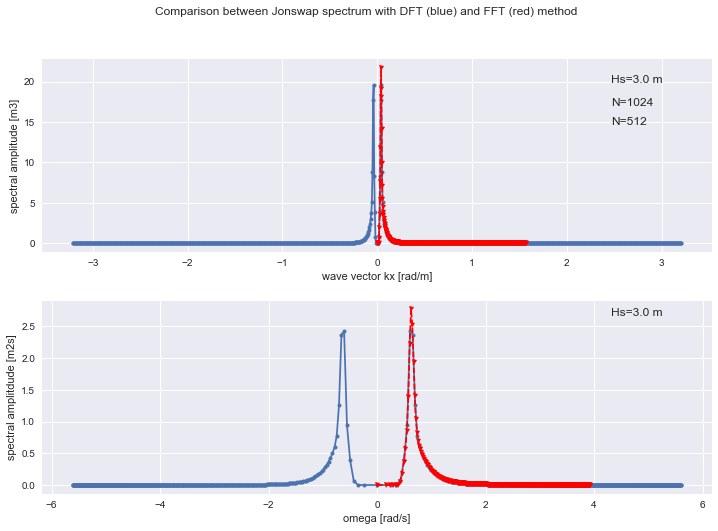

In [19]:
fig, axis=wave3.plot_spectrum(add_limit_markers=False, add_hs_estimate=True, figsize=(12,8), 
                              plot_title="Comparison between Jonswap spectrum with DFT (blue) and FFT (red) method")
fig, axis=wave1.plot_spectrum(fig=fig, axis=axis, linecolor="r", linestyle="--", line_markers="v",
                              y_n_points_label=0.7, markersize=5, add_hs_estimate=False)
plt.show()

In [20]:
wave1.reset_time(nt_samples=1000)
with Timer(message=wave1.name) as t:
    while wave1.time < wave1.t_end:
        wave1.propagate_wave()

wave_jonswap_DFTpolar_All_1d routine              :       5818 ms


In [21]:
wave3.reset_time(nt_samples=1000)
with Timer(message=wave3.name) as t:
    while wave3.time < wave1.t_end:
        wave3.propagate_wave()

wave_jonswap_FFT_All_1d routine              :        380 ms


The same reduction in simulation time is achieved by using the FFT construction method as that we achieved by using less points in k-space with the EqualEnergyBins method. Now let's compare the wave animation again

In [22]:
wave1.reset_time(nt_samples=500, delta_t=0.1)
movie1 = wave1.animate_wave(plot_title="Jonswap wave using FFT at 512 nodes", y_min=-2, y_max=2)
HTML(movie1.to_html5_video())

In [23]:
plt.gcf().clear()

In [24]:
wave3.reset_time(nt_samples=500, delta_t=0.1)
movie3 = wave1.animate_wave(plot_title="Jonswap wave using DFT at 512 nodes", y_min=-2, y_max=2)
HTML(movie3.to_html5_video())

In [25]:
plt.gcf().clear()

This time we can see that the waves are identical in terms of details on both high and low frequency components, which is not surprising as the spectra are the same. The Hs related to the waves is also equal, as becomes clear from the Hs shown in the spectral plot. Alternatively we could compare the hs estimate from the amplitude for both signals:

In [26]:
hs_1 = 4 * np.sqrt(wave1.amplitude.var())
hs_2 = 4 * np.sqrt(wave2.amplitude.var())
hs_3 = 4 * np.sqrt(wave3.amplitude.var())
logger.info("Hs wave 1 = {:.1f} m\nHs wave 2 = {:.1f} m\nHs wave 3 = {:.1f} m".format(hs_1, hs_2, hs_3))

Hs wave 1 = 2.5 m
Hs wave 2 = 3.4 m
Hs wave 3 = 3.0 m


The reason that wave 3 has the most accurate representation of Hs in the time domain is that it as twice as much samples over the whole domain. This was as we needed to compensate for the redution in k-resolution as the k-domain is twice as large (running from -k to +k). If you would measure the amplitude over more time samples all estimates approach to true value of 3.0 m. Let check that:


In [27]:
for wave in (wave1, wave2, wave3):
    wave.reset_time(delta_t=100, nt_samples=20)
    energy = 0
    n_waves = 0
    while wave.time < wave.t_end:
        wave.propagate_wave()
        energy += wave.amplitude.var()
        n_waves += 1
    energy /= n_waves
    hs_estimate = 4 * np.sqrt(energy)
    logger.info("Wave {:50s} : Hs = {:.2f} m".format(wave.name, hs_estimate))
    

Wave wave_jonswap_DFTpolar_All_1d                       : Hs = 3.00 m
Wave wave_jonswap_DFTpolar_EqualEnergyBins_1d           : Hs = 3.04 m
Wave wave_jonswap_FFT_All_1d                            : Hs = 3.00 m


Indeed all waves have an Hs within 1% near the target value of Hs=3 m

<a id='gausswave'></a>

## Simulating a Gauss wave

The implementation of the wave equation does not need the details of the shape of the energy spectrum. For now only the Jonswap and Gauss spectrum have been included, but in the future this could be extented to multi-component wave or other spectra as well. Let's first see how we would create a Gauss wave

In [28]:
wave4 = wf.Wave1D(xmax=1000, nx_points=512, n_kx_nodes=512, spectrum_type="gauss", wave_construction="DFTcartesian")
wave4.make_report()

Initialise gauss 1D wave field
Name                                     : wave_gauss_DFTcartesian_All_1d
----------- Domain settings --------
Start x [m]                              : 0
End x [m]                                : 1000
Length x [m]                             : 1000
----------- Time settings --------
Start t [s]                              : 0
End t [s]                                : 1000000
Length t [s]                             : 1000000
Delta t [s]                              : 1.0
----------- Numerical resolutions --------
Number x - nodes                         : 512
Number kx - nodes                        : 512
Delta x [m]                              : 1.9569471624266144
Delta kx min [rad/m]                     : -3.204436778507892
Delta kx max [rad/m]                     : 0.006270913460876715
Delta kx first [rad/m]                   : 0.006270913460876501
k-min [rad/m]                            : -1.6053538459843844
k-max [rad/m]                       

In [29]:
wave5 = wf.Wave1D(xmax=1000, nx_points=512, n_kx_nodes=512, spectrum_type="gauss", wave_construction="FFT")
wave5.make_report()

Initialise gauss 1D wave field
Name                                     : wave_gauss_FFT_All_1d
----------- Domain settings --------
Start x [m]                              : 0
End x [m]                                : 1000
Length x [m]                             : 1000
----------- Time settings --------
Start t [s]                              : 0
End t [s]                                : 1000000
Length t [s]                             : 1000000
Delta t [s]                              : 1.0
----------- Numerical resolutions --------
Number x - nodes                         : 512
Number kx - nodes                        : 512
Delta x [m]                              : 1.9569471624266144
Delta kx min [rad/m]                     : -3.204436778507892
Delta kx max [rad/m]                     : 0.006270913460876715
Delta kx first [rad/m]                   : 0.006270913460876501
k-min [rad/m]                            : -1.6053538459843844
k-max [rad/m]                            : 1.

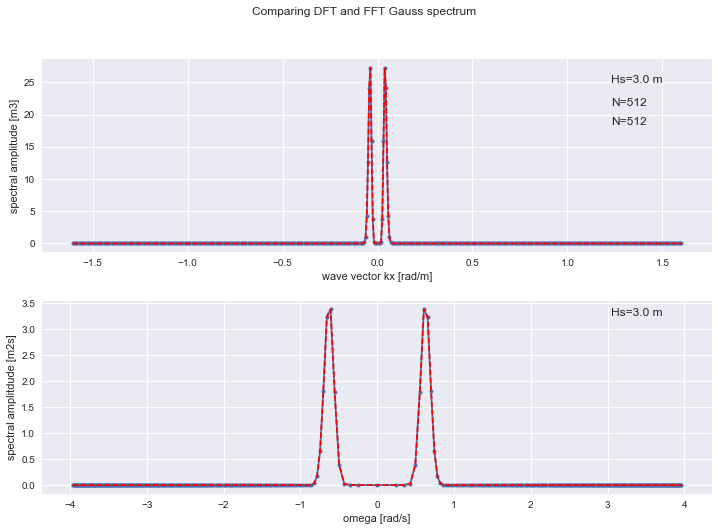

In [30]:
fig, axis=wave4.plot_spectrum(add_limit_markers=False, add_hs_estimate=True, figsize=(12,8),
                             plot_title="Comparing DFT and FFT Gauss spectrum ")
fig, axis=wave5.plot_spectrum(fig=fig, axis=axis, linecolor="r", linestyle="--", line_markers="v",
                              y_n_points_label=0.7, markersize=1, add_hs_estimate=False)
plt.show()

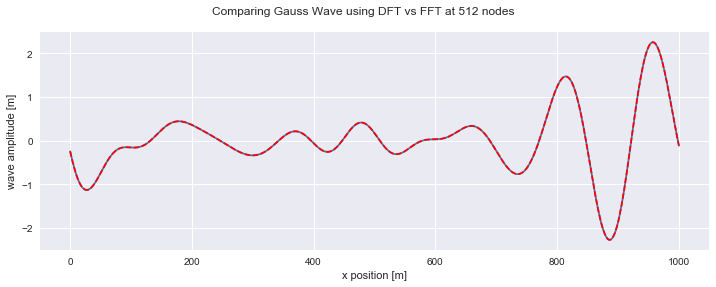

In [31]:
fig, axis = wave4.plot_wave(plot_title="Comparing Gauss Wave using DFT vs FFT at 512 nodes")
fig, axis = wave5.plot_wave(fig=fig, ax=axis, linestyle="--", linecolor="r")
plt.show()

As expected, as both the FFT and DFTcartesian wave construction method use the same symmetric spectrum, both waves are plotted on top of each other. Let's check that the FFT is indeed much faster than the DFT again

In [32]:
wave4.reset_time(nt_samples=1000)
with Timer(message=wave4.name) as t:
    while wave4.time < wave4.t_end:
        wave4.propagate_wave()

wave_gauss_DFTcartesian_All_1d routine              :       6362 ms


In [33]:
wave5.reset_time(nt_samples=1000)
with Timer(message=wave5.name) as t:
    while wave5.time < wave5.t_end:
        wave5.propagate_wave()

wave_gauss_FFT_All_1d routine              :        294 ms


Check: again our FFT version is about 20 times faster than the DFT version. 

The lesson learned: when simulating wave fields: always use an FFT if simulation time is in issue. In contrast to the wave selection method such as the EqualEnergyBin we do not pay the price in the reduction of the high frequency wave components, but we can still obtain a reduction in simulation time. Note further that the simulation time of a DFT scales with N^2, whereas the FFT scale with Nlog(N), so especially for 2D spectra it is important to pick the most efficient algorithm

Let's close with an animation of our Gauss wave. Of course we pick our FFT version for that: it is 20 times faster than a DFT and still we don't lose the details on the high frequency components in the spectrum.

In [34]:
wave5.reset_time(nt_samples=500, delta_t=0.25)
movie5= wave5.animate_wave(plot_title="Propagate Gauss wave using FFT")
HTML(movie5.to_html5_video())

In [35]:
plt.gcf().clear()